# Calculating & Investigating final number density plot

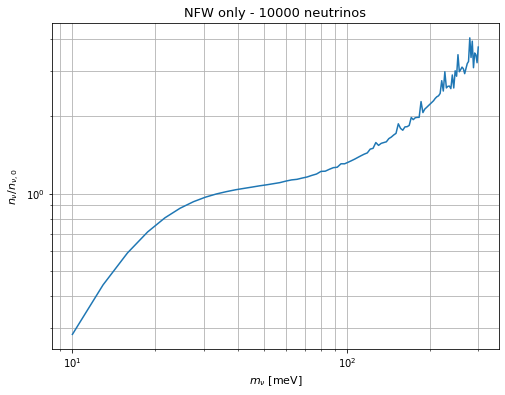

Max value: 453.25916548148564 4.046956834656122


In [1]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC


def number_density_1_mass(m_sim_eV, m_nu_eV):

    # load initial and final velocity
    Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)  # Nr. of neutrinos
    sim = np.array([np.load(f'neutrino_vectors/nu_{Nr+1}.npy') for Nr in Ns])
    u_all = sim[:,:,3:6]  # (10000, 100, 3) shape, ndim = 3


    n_nus = np.zeros(len(m_nu_eV))
    for i, m_eV in enumerate(m_nu_eV):

        # Get momenta.
        p, _ = fct.u_to_p_eV(u_all, m_sim_eV, m_eV)

        # Calculate number density.
        n_nus[i] = fct.number_density(p[:,0], p[:,-1], CC.Z_STOP).value

    np.save('neutrino_data/number_densities.npy', n_nus)



# 10 to 300 meV like in the paper
mass_range_eV = np.linspace(0.01, 0.3, 100)*unit.eV

number_density_1_mass(CC.NU_MASS, mass_range_eV)
n_nus = np.load('neutrino_data/number_densities.npy')

neutrinos = CC.NR_OF_NEUTRINOS
plt.figure(figsize=(8,6))
plt.loglog(mass_range_eV*1e3, (n_nus/CC.N0))
plt.title(f'NFW only - {neutrinos} neutrinos')
plt.xlabel(r'$m_{\nu}$ [meV]')
plt.ylabel(r'$n_{\nu} / n_{\nu, 0}$')
plt.grid(True, which="both", ls="-")
plt.savefig(f'check_plots/densities_{neutrinos}_nus.pdf')
plt.show()

print('Max value:', np.max(n_nus), np.max(n_nus/CC.N0))

## Momentum behaviour

In [ ]:
# Amount of simulated neutrinos
Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)

# load initial and final velocity
u0 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[0,3:6] for Nr in Ns]
u1 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[-1,3:6] for Nr in Ns]

# magnitude of velocities
a0 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u0)])
a1 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u1)])

# 10 to 300 meV like in the paper
mass_range_eV = np.linspace(0.01, 0.3, 3) * unit.eV


mom = []
for m_eV in mass_range_eV:

    # calculate momenta
    m = m_eV.to(unit.kg, unit.mass_energy()).value
    p_unit = unit.kg*unit.kpc/unit.s
    p0, p1 = a0 * m * p_unit, a1 * m * p_unit

    # convert momenta from kg*kpc/s to eV
    to_eV = 1/(5.3442883e-28)
    p0 = p0.to(unit.kg*unit.m/unit.s).value * to_eV
    p1 = p1.to(unit.kg*unit.m/unit.s).value * to_eV

    # sort arrays
    order = p0.argsort()
    p0, p1 = p0[order], p1[order]
    mom.append(p0)


x = np.arange(len(p0))
plt.semilogy(x, mom[0], label=f'm={mass_range_eV[0]} eV')
plt.semilogy(x, mom[1], label=f'm={mass_range_eV[1]} eV')
plt.semilogy(x, mom[2], label=f'm={mass_range_eV[2]} eV')
plt.legend()
plt.show()

In [ ]:
# Amount of simulated neutrinos
Ns = np.arange(CC.NR_OF_NEUTRINOS, dtype=int)

# load initial and final velocity
u0 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[0,3:6] for Nr in Ns]
u1 = [np.load(f'neutrino_vectors/nu_{Nr+1}.npy')[-1,3:6] for Nr in Ns]

# magnitude of velocities
m0 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u0)])
m1 = np.array([np.sqrt(np.sum(u**2)) for u in np.array(u1)])

# calculate momenta
m = CC.NU_MASS_KG.value
p_unit = unit.kg*unit.kpc/unit.s
p0, p1 = m0 * m * p_unit, m1 * m * p_unit

# sort arrays
order = p0.argsort()
p0, p1 = p0[order], p1[order]

# convert momenta from kg*kpc/s to eV
to_eV = 1/(5.3442883e-28)
p0 = p0.to(unit.kg*unit.m/unit.s).value * to_eV
p1 = p1.to(unit.kg*unit.m/unit.s).value * to_eV

x = np.arange(len(p0))

plt.title('Neutrino momenta (ascended sorted)')
plt.xlabel('Neutrino')
plt.ylabel(r'p $\left[ \frac{kg \cdot kpc}{s} \right]$')
plt.semilogy(x, p0, label='initial')
plt.semilogy(x, p1*(1.), label='final', alpha=0.7)
plt.legend()
plt.savefig('check_plots/neutrino_momenta.pdf')
plt.show()


same = True
for a,b in zip(p0,p1):

    if a != b:
        same = False

print(same)    

#! function is stepwise because each value of velocity has multiple angles

## Fermi-Dirac shape

In [ ]:
# Original Fermi-Dirac distr.
pOG = np.geomspace(0.01*my.T_nu_eV, 10*my.T_nu_eV, len(p0))
FDvalsOG = fct.Fermi_Dirac(pOG, CC.Z_STOP)
yOG = pOG/my.T_nu_eV.value

# Fermi-Dirac distr. of initial momentum (by using p1 momenta at z_back)
y0 = p0/my.T_nu_eV.value
FDvals0 = fct.Fermi_Dirac(p1, CC.Z_STOP)

# Fermi-Dirac distr. of final momentum
y1 = p1/my.T_nu_eV.value
FDvals1 = fct.Fermi_Dirac(p1, CC.Z_STOP)

print(np.mean(FDvals0[0:5000]), np.mean(FDvals1[0:5000]))

# plt.rcParams["figure.figsize"] = (8,6)  # global
plt.figure(figsize=(8,6))
plt.loglog(y0, FDvals0, label='today', c='red')
plt.loglog(y1, FDvals1, label='z_back', c='black', ls=':')
plt.loglog(yOG, FDvalsOG, label='Fermi-Dirac', c='blue', alpha=0.4)
plt.title('Fermi-Dirac distr. m=0.05 eV')
plt.ylabel('f(y)')
plt.xlabel('y=p/T_nu')
plt.legend(loc='lower left')
plt.savefig('check_plots/fermi_dirac_distr.pdf')
plt.show()

In [ ]:
def Fermi_Dirac_Ringwald_and_Wong(p):
    # Plug into Fermi-Dirac distribution 
    arg_of_exp = p/my.T_nu_eV
    f_of_p = 1 / (np.exp(arg_of_exp.value) + 1)

    return f_of_p

# Original Fermi-Dirac distr.
pOG = np.geomspace(0.01*my.T_nu_eV, 13*my.T_nu_eV, len(p0))
FDvalsOG = Fermi_Dirac_Ringwald_and_Wong(pOG)
yOG = pOG/my.T_nu_eV.value

plt.loglog(yOG, FDvalsOG, label='Fermi-Dirac')
plt.title('Fermi-Dirac distr. of initial momentum')
plt.ylabel('f(y)')
plt.xlabel('y=p/T_nu')
plt.legend(loc='lower left')
plt.savefig('check_plots/fermi_dirac_distr.pdf')